# Overview

For this project, I wanted to come up with a simple example to get more experience working with Convolutional Neural Networks. I decided I wanted to work on a project from scratch, but I also wanted to keep it fairly simple. I wanted to start with nothing, create my own image data set, and use it in a model. I decided I would make a model for detecting my hand using my webcam. The idea was to draw a bounding box around my hand in videos captured using the webcam.

Initially I began by creating a small dataset of images and a basic model. As I iterated through the process of trying to improve my results, I added more images and made tweaks to the model. The following notebook is the final version of the dataset and model that I used. The full directory of previos attempts and models can be found on my [my Github page.](https://github.com/DL-Thompson/) This specific notebook can be found [here.](https://github.com/DL-Thompson/USMOnlineJudge)

As can be seen in the two result videos below, the project was a success. The two videos below were not part of the training/validation/test sets.

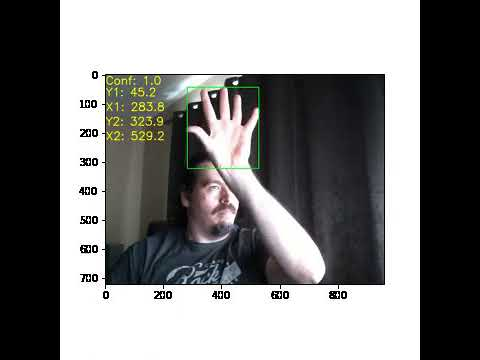

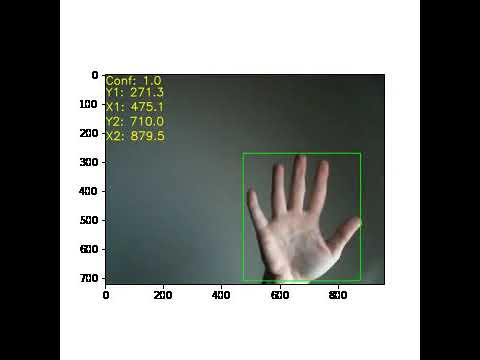

In [1]:
from IPython.display import YouTubeVideo
display(YouTubeVideo('KGgFYSOsrSk', width=360, height=360))
display(YouTubeVideo('3mq0tE7Ft7Q', width=360, height=360))

# The Dataset

The dataset was created using a Logitech C615 webcam. The video was taken at a resolution of 960x720. That was the default resolution of the webcam program I used, it wasn't chosen for any specific reason.

Over the course of the project, several videos were taken using the webcam. The videos frames were then converted to images using ffmpeg. The dataset was constructed in a way so there was only one hand or no hand in each image. I then created bounding boxes around the hand in images that contained a hand using labelImg. 

Videos consisted of two types. The first type being where my face/body were included in the video. The second type being just a hand and/or partial arm in the video. Included in the dataset were also negative examples which included images taken from the video which contained no hand.

Data created from the videos were added in four different phases. The first phase contained 786 positive examples and 155 negative examples. After the model performed poorly, I added a second phase of 275 positive examples and 22 negative examples. The model still performed poorly, so I took the time with the third phase to more than double the data by adding 1638 positive examples and 123 negative examples. The model was performing better at this point, but was still having trouble detecting the hand when it was near my face, so I added a fourth phase which contained 281 positive examples and 24 negative examples focusing on examples that contained a hand near and far from my face. The dataset contains a total of 2980 positive examples and 324 negative examples.

The images were labeled by hand. Each image has five target values. The first value is a confidence value of 1 if the image contains a hand and 0 if the image doesn't. The second through fifth values are two x,y coordinate pairs that make up the bounding box for the hand. These x, y coordinates are 0 if no hand is contained in the image.

After labeling the images, I then flipped the entire dataset along the horizontal axis. This doubled the dataset size to a total of 5960 positive examples and 648 negative examples. Annotations for bounding boxes were updates to reflect this flip.

## Looking at the Data

The video below displays a sample of the data along with targets from the training set. The target bounding box is drawn around the hand in red. If there is no hand in the image (0 confidence), no bounding box is drawn.

In [2]:
import os
#Turn off tensorflow messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
#Set second GPU as visible
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

import keras
from keras.callbacks import EarlyStopping
import keras.backend as K
import tensorflow as tf
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cv2
from IPython.display import HTML
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from imgaug import augmenters as iaa
from shutil import copyfile

def play_images_from_directory(directory, json_file, num_to_iter=1, model=None, prediction_threshold=0.5):
    #num_to_iter: number of images to skip when iterating to create video
    assert json_file is not None
    assert os.path.isdir(directory)
    assert os.path.isfile(directory + json_file)
    
    fig, ax = plt.subplots(figsize=(5,5))
    
    if json_file is not None:
        json_file = open(directory + json_file)
        json_data = json.load(json_file)
        
        annotation_dict = {}
        for entry in json_data:
            width = entry['annotations'][0]['coordinates']['width']
            height = entry['annotations'][0]['coordinates']['height']
            x1 = entry['annotations'][0]['coordinates']['x'] - width / 2
            y1 = entry['annotations'][0]['coordinates']['y'] - height / 2
            x2 = x1 + width
            y2 = y1 + height
            file_name = entry['image']
            confidence = 0 if width == 0 and height == 0 and x1 == 0 and y1 == 0 else 1.0
            annotation_dict[file_name] = [confidence, y1, x1, y2, x2]
    
    animation_images = []
    iter_count = 0
    for file_name in os.listdir(directory):
        if iter_count % num_to_iter != 0:
            iter_count += 1
            continue
        if file_name.endswith('.jpg'):
            image = cv2.imread(directory + file_name)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            if json_file is not None:
                annotation = annotation_dict[file_name]
                if annotation[0] == 1.0:
                    y1 = annotation[1]
                    x1 = annotation[2]
                    y2 = annotation[3]
                    x2 = annotation[4]
                    cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)
            if model is not None:
                #If a model is passed in, do prediction and display some metric data
                image_copy = image.copy() / 255.0
                image_copy = cv2.resize(image_copy, (224, 224))
                prediction = model.predict(np.reshape(image_copy, (1, 224, 224, 3)))
                conf_pred = prediction[0][0][0]
                iou_result = 0.0
                if conf_pred > prediction_threshold:
                    pred_y1 = prediction[1][0][0] * 720
                    pred_x1 = prediction[1][0][1] * 960
                    pred_y2 = prediction[1][0][2] * 720
                    pred_x2 = prediction[1][0][3] * 960
                    cv2.rectangle(image, (int(pred_x1), int(pred_y1)), (int(pred_x2), int(pred_y2)), (0, 255, 0), 2)
                    iou_metric = IOU_Metric()
                    y_true = tf.convert_to_tensor([annotation[1:]], dtype=tf.float32)
                    y_pred = tf.convert_to_tensor([[pred_y1, pred_x1, pred_y2, pred_x2]], dtype=tf.float32)
                    iou_metric.update_state(y_true, y_pred)
                    iou_result = K.get_value(iou_metric.result())
                cv2.putText(image, 'Conf: {:.2f}'.format(conf_pred), (2, 36), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 0), 2, cv2.LINE_AA)
                cv2.putText(image, 'IoU: {:.2f}'.format(iou_result), (2, 80), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 0), 2, cv2.LINE_AA)
            animation_images.append([ax.imshow(image)])
            iter_count += 1
        
    ani = animation.ArtistAnimation(fig, animation_images, interval=250, blit=True)
    plt.close()
    return HTML(ani.to_html5_video())

display(play_images_from_directory('./data/train/positive/', 'annotations.json', num_to_iter=150))
display(play_images_from_directory('./data/train/negative/', 'annotations.json', num_to_iter=15))

## Data Augmentation

The initial training set by itself wasn't enough to produce a good model. To increase the dataset size, I augmented the training images using imgAug. For each image in the training set, a random augmentation was applied and the new image saved. This was repeated over the entire training set multiple times until the set was large enoough.

Augmentations included:
- Scale: Zoom out on the image from 75% to 95%
- Translate: Shift the image up/down and left right between -20% to 20%
- Rotate: Rotate the image left and right -10 to 10 degrees
- Shear: Shifts the top parts of the image one direction and the bottom parts another direction by -10 to 10 degrees

Each image that is augmented applies a random value from the four augmentations. Even though the same starting image may be augmented multiple times, each outcome should be different.

When performing augmentations on the image, certain sections along the edge of the image may be left with no information. To fill in these blank spaces, the last pixel value from the image edge is extended out to fill in the missing data.

When augmenting the image, it is also possible that the hand could be moved out of the image. To correct for this, only images where the augmented bounding box values are 75% contained within the image are kept. For example, if a hand and its bounding box is in the top left corner, and the image is augmented to rotate left, it's possible the hand could be rotated out of the new image. If more than 25% of the augmented bounding box values fall outside of the image after rotation, that image is discarded.

Below, a video shows what the augmented images looks like.

In [3]:
def create_augmented_images(directory_list, json_list, save_directory, num_augmented, bounding_percentage=0.25):
    #bounding_percentage : percent of augmented bounding box outside of the image before its thrown out
    def generate_augmented_image(image, annotation):
        success = False
        while success == False:
            bounding_box = BoundingBoxesOnImage([BoundingBox(x1=annotation[2], 
                                                             x2=annotation[4], 
                                                             y1=annotation[1], 
                                                             y2=annotation[3], 
                                                             label='hand' if annotation[0] == 1.0 else 0)], 
                                                shape=image.shape)
            seq = iaa.Sequential([iaa.Affine(scale=(0.75, 0.95), 
                                             translate_percent=(-0.2, 0.2), 
                                             rotate=(-10, 10), 
                                             shear=(-10, 10), 
                                             mode='edge'), 
                                  iaa.PerspectiveTransform(scale=(0.01, 0.15), mode='replicate')])
            image_aug, bb_aug = seq(images=[image], bounding_boxes=bounding_box)    
            fraction = bb_aug.bounding_boxes[0].compute_out_of_image_fraction(image_aug[0])
            if fraction <= bounding_percentage:
                #bounding box is inside image
                success = True
                bb = bb_aug.bounding_boxes[0].clip_out_of_image(image_aug[0])
                y1 = bb.y1_int
                x1 = bb.x1_int
                y2 = bb.y2_int
                x2 = bb.x2_int
                augmented_image = image_aug[0]
                if bb_aug.bounding_boxes[0].label == 'hand':
                    augmented_annotation = [1.0, y1, x1, y2, x2]
                else:
                    augmented_annotation = [0, 0, 0, 0, 0]
        return augmented_image, augmented_annotation
    
    def get_annotation(entry):
        width = entry['annotations'][0]['coordinates']['width']
        height = entry['annotations'][0]['coordinates']['height']
        x = entry['annotations'][0]['coordinates']['x'] - width / 2
        y = entry['annotations'][0]['coordinates']['y'] - height / 2
        if width == 0 and height == 0:
            confidence = 0
        else:
            confidence = 1
        return [confidence, y, x, y + height, x + width]
    
    def get_json_entry(json_file_name, json_annotation):
        width = json_annotation[4] - json_annotation[2]
        height = json_annotation[3] - json_annotation[1]
        x = json_annotation[2] + width / 2
        y = json_annotation[1] + height / 2
        return {'image' : json_file_name, 
                'annotations' : [{'label' : 'hand', 
                                  'coordinates' : {'x' : float(x), 
                                                   'y' : float(y), 
                                                   'width' : float(width), 
                                                   'height' : float(height)}}]}
    json_annotation_file = []
    augment_count = 0
    while augment_count < num_augmented:
        current_count = 0
        for i, directory in enumerate(directory_list):
            print('Augmenting directory: ', directory)
            if augment_count >= num_augmented:
                print(' Number augmented: ', current_count)
                break
            image = None
            annotation = None
            if json_list[i] is not None:
                #files are positive examples with a json file containing annotations
                json_file = open(directory + json_list[i])
                json_data = json.load(json_file)
                for entry in json_data:
                    file_name = entry['image']
                    image = cv2.imread(directory + file_name)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    annotation = get_annotation(entry)
                    augmented_image, augmented_annotation = generate_augmented_image(image, annotation)
                    augmented_image = cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR)
                    save_name = str(augment_count + 1).zfill(5) + '.jpg'
                    cv2.imwrite(save_directory + save_name, augmented_image)
                    json_annotation_file.append(get_json_entry(save_name, augmented_annotation))
                    augment_count += 1
                    current_count += 1
                    if augment_count == num_augmented:
                        break
            else:
                #files are negative examples with no json file
                for file_name in os.listdir(directory):
                    if file_name.endswith('.jpg'):
                        image = cv2.imread(directory + file_name)
                        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                        annotation = [0, 0, 0, 0, 0]
                        augmented_image, augmented_annotation = generate_augmented_image(image, annotation)
                        augmented_image = cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR)
                        save_name = str(augment_count + 1).zfill(5) + '.jpg'
                        cv2.imwrite(save_directory + save_name, augmented_image)
                        json_annotation_file.append(get_json_entry(save_name, augmented_annotation))
                        augment_count += 1
                        current_count += 1
                        if augment_count == num_augmented:
                            break
            print(' Number augmented in {}: {}'.format(directory, current_count))
            current_count = 0
    print('Total augmented: {}'.format(len(json_annotation_file)))
    assert len(json_annotation_file) > 0
    json_dict = json.dumps(json_annotation_file)
    f = open(save_directory + 'annotations.json', 'w')
    f.write(json_dict)
    f.close()

!mkdir -p ./data/augmented_tmp/positive
create_augmented_images(['./data/train/positive/'], ['annotations.json'], './data/augmented_tmp/positive/', 30000)

!mkdir -p ./data/augmented_tmp/negative
create_augmented_images(['./data/train/negative/'], [None], './data/augmented_tmp/negative/', 10000)

display(play_images_from_directory('./data/augmented_tmp/positive/', 'annotations.json', num_to_iter=750))
display(play_images_from_directory('./data/augmented_tmp/negative/', 'annotations.json', num_to_iter=200))

Augmenting directory:  ./data/train/positive/
 Number augmented in ./data/train/positive/: 5960
Augmenting directory:  ./data/train/positive/
 Number augmented in ./data/train/positive/: 5960
Augmenting directory:  ./data/train/positive/
 Number augmented in ./data/train/positive/: 5960
Augmenting directory:  ./data/train/positive/
 Number augmented in ./data/train/positive/: 5960
Augmenting directory:  ./data/train/positive/
 Number augmented in ./data/train/positive/: 5960
Augmenting directory:  ./data/train/positive/
 Number augmented in ./data/train/positive/: 200
Total augmented: 30000
Augmenting directory:  ./data/train/negative/
 Number augmented in ./data/train/negative/: 648
Augmenting directory:  ./data/train/negative/
 Number augmented in ./data/train/negative/: 648
Augmenting directory:  ./data/train/negative/
 Number augmented in ./data/train/negative/: 648
Augmenting directory:  ./data/train/negative/
 Number augmented in ./data/train/negative/: 648
Augmenting directory: 

The section below combines the original data with the augmented data into a separate directory to be used for training.

In [4]:
def copy_image_directories(image_directory_list, json_list, copy_directory):
    assert len(image_directory_list) == len(json_list)
    assert os.path.isdir(copy_directory)
    for i in range(len(image_directory_list)):
        assert os.path.isdir(image_directory_list[i])
        if json_list[i] is not None:
            assert os.path.isfile(image_directory_list[i] + json_list[i])
    file_count = 0
    file_names = []
    file_in_paths = []
    file_out_paths = []
    target_values = []
    for i in range(len(image_directory_list)):
        #set of positive examples or negative examples with json file
        if json_list[i] is not None:
            json_file = open(image_directory_list[i] + json_list[i])
            json_data = json.load(json_file)
            for entry in json_data:
                file_name = entry['image']
                width = entry['annotations'][0]['coordinates']['width']
                height = entry['annotations'][0]['coordinates']['height']
                x = entry['annotations'][0]['coordinates']['x']
                y = entry['annotations'][0]['coordinates']['y']
                file_out_name = str(file_count+1).zfill(5) + '.jpg'
                file_names.append(file_out_name)
                file_count += 1
                file_in_paths.append(image_directory_list[i] + file_name)
                file_out_paths.append(copy_directory + file_out_name)
                target_values.append([x, y, width, height])
        #set of negative examples with no json file
        else:
            for file_name in os.listdir(image_directory_list[i]):
                if file_name.endswith('.jpg'):
                    file_out_name = str(file_count+1).zfill(5) + '.jpg'
                    file_names.append(file_out_name)
                    file_count += 1
                    file_in_paths.append(image_directory_list[i] + file_name)
                    file_out_paths.append(copy_directory + file_out_name)
                    target_values.append([0, 0, 0, 0])
    
    assert len(file_in_paths) == len(file_out_paths)
    assert len(file_in_paths) == len(target_values)
    json_data = []
    for i in range(len(target_values)):
        copyfile(file_in_paths[i], file_out_paths[i])
        x = target_values[i][0]
        y = target_values[i][1]
        width = target_values[i][2]
        height = target_values[i][3]
        json_data.append({
                'image' : file_names[i],
                'annotations' : [
                    {
                        'label' : 'hand',
                        'coordinates' : {
                            'x' : x,
                            'y' : y,
                            'width' : width,
                            'height' : height}}]})
    assert len(json_data) > 0
    json_dict = json.dumps(json_data)
    f = open(copy_directory + 'annotations.json', 'w')
    f.write(json_dict)
    f.close()
    
!mkdir -p ./data/train_augmented
copy_image_directories(['./data/train/positive/', './data/train/negative/', './data/augmented_tmp/positive/', './data/augmented_tmp/negative/'], ['annotations.json'] * 4, './data/train_augmented/')
!rm -rf ./data/augmented_tmp

## Data Generator

When a dataset is made up of image files, which can be quite large, memory issues often arise. In order to prevent memory issues in this project, I will extend the Keras Sequence class to create a data generator object. This object loads only the images that are needed for a batch. It does not require storing the entire dataset in memory. It draws a batch from the dataset at each iteration of the batches, and at the end of the epoch, it shuffles the dataset for the next epoch. For each image that is pulled, the pixel values are divided by 255 so all values are between 0 and 1.

The data generator also requires a Pandas DataFrame object that contains the file path of each image and the target variables for each image. Below, I will define the DataGenerator class and a dataframe for the training, validation, and test data. At the end, a preview of the dataframes are shown which has the filename, confidence, and scaled x,y coordinates.

In [5]:
IMAGE_HEIGHT = 720
IMAGE_WIDTH = 960

class DataGenerator(keras.utils.Sequence):
    def __init__(self, df, y_cols, directory=None, batch_size=32, dim=(224, 224), n_channels=3, shuffle=True):
        self.df = df.reset_index(drop=True)
        self.y_cols = y_cols
        self.directory = directory
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        indexes = self.df.index.tolist()[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)
        return X, y

    def on_epoch_end(self):
        if self.shuffle == True:
            self.df = self.df.sample(frac=1.0)

    def __data_generation(self, indexes):
        X = np.empty((self.batch_size, *self.dim, self.n_channels), dtype=np.float32)
        for i, index in enumerate(indexes):
            if self.directory is not None:
                file_path = self.directory + self.df.iloc[index]['id']
            else:
                file_path = self.df.iloc[index]['id']
            image = cv2.imread(file_path)
            image = cv2.resize(image, self.dim)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = image.astype(np.float32) / 255.0
            X[i,] = image
        y = self.df.iloc[indexes,:][self.y_cols].to_numpy()
        return X, [y[:,0], y[:,1:]]
    
    def get_total_length(self):
        return self.df.shape[0]
    
    def get_entry(self, index):
        #returns the image and targets for a single index
        if index >= self.df.shape[0]:
            return None, None, None
        X, y = self.__data_generation([index])
        return X[0].copy(), y[0][0].copy(), y[1][0].copy()
    
    def get_positive_count(self):
        #return the number of positive training examples
        if 1 in self.df['confidence'].value_counts():
            return int(self.df['confidence'].value_counts()[1])
        else:
            return 0
        
    def get_negative_count(self):
        #return the number of negative training examples
        if 0 in self.df['confidence'].value_counts():
            return int(self.df['confidence'].value_counts()[0])
        else:
            return 0
        
def load_dataframe(directory, json_file):
    assert json_file is not None
    assert os.path.isdir(directory)
    assert os.path.isfile(directory + json_file)
    file_names = []
    confidence_values = []
    y1_values, x1_values, y2_values, x2_values = [], [], [], []
    
    json_file = open(directory + json_file)
    json_data = json.load(json_file)
    for entry in json_data:
        #load annotations, annotations are center of box, convert to x1,y1 and width, height
        width = entry['annotations'][0]['coordinates']['width']
        height = entry['annotations'][0]['coordinates']['height']
        x = entry['annotations'][0]['coordinates']['x'] - width / 2
        y = entry['annotations'][0]['coordinates']['y'] - height / 2
        file_name = entry['image']
        confidence_value = 1.0
        if width == 0 and height == 0 and x == 0 and y == 0:
            confidence_value = float(0)
        confidence_values.append(confidence_value)
        y1_values.append(y)
        x1_values.append(x)
        y2_values.append(y + height)
        x2_values.append(x + width)
        file_names.append(file_name)

    df = pd.DataFrame(data={'id' : file_names, 
                            'confidence' : confidence_values, 
                            'y1' : y1_values, 
                            'x1' : x1_values, 
                            'y2' : y2_values, 
                            'x2' : x2_values})
    df['y1'] = df['y1'].apply(np.round)
    df['x1'] = df['x1'].apply(np.round)
    df['y2'] = df['y2'].apply(np.round)
    df['x2'] = df['x2'].apply(np.round)
    #sanity check that all target values fall within the correct range
    for index, row in df.iterrows():
        assert row['confidence'] == 1.0 or row['confidence'] == 0
        assert row['y1'] >= 0 and row['y1'] <= 720
        assert row['x1'] >= 0 and row['x1'] <= 960
        assert row['y2'] >= 0 and row['y2'] <= 720
        assert row['x2'] >= 0 and row['x2'] <= 960
    return df

#load dataframes with filenames and target data, then scale x,y coordinate data to be between 0 and 1
df_train = load_dataframe('./data/train_augmented/', 'annotations.json')
df_train['y1'] = df_train['y1'] / IMAGE_HEIGHT
df_train['x1'] = df_train['x1'] / IMAGE_WIDTH
df_train['y2'] = df_train['y2'] / IMAGE_HEIGHT
df_train['x2'] = df_train['x2'] / IMAGE_WIDTH

df_validation = load_dataframe('./data/validation/', 'annotations.json')
df_validation['y1'] = df_validation['y1'] / IMAGE_HEIGHT
df_validation['x1'] = df_validation['x1'] / IMAGE_WIDTH
df_validation['y2'] = df_validation['y2'] / IMAGE_HEIGHT
df_validation['x2'] = df_validation['x2'] / IMAGE_WIDTH

df_test = load_dataframe('./data/test/', 'annotations.json')
df_test['y1'] = df_test['y1'] / IMAGE_HEIGHT
df_test['x1'] = df_test['x1'] / IMAGE_WIDTH
df_test['y2'] = df_test['y2'] / IMAGE_HEIGHT
df_test['x2'] = df_test['x2'] / IMAGE_WIDTH

y_cols = ['confidence', 'y1', 'x1', 'y2', 'x2']
train_datagen = DataGenerator(df_train, y_cols, directory='./data/train_augmented/')
validation_datagen = DataGenerator(df_validation, y_cols, directory='./data/validation/')
test_datagen = DataGenerator(df_test, y_cols, directory='./data/test/')

display(df_train, df_validation, df_test)

id  confidence        y1        x1        y2        x2
0      00001.jpg         1.0  0.211111  0.145833  0.551389  0.360417
1      00002.jpg         1.0  0.200000  0.145833  0.559722  0.359375
2      00003.jpg         1.0  0.197222  0.143750  0.558333  0.360417
3      00004.jpg         1.0  0.200000  0.145833  0.562500  0.358333
4      00005.jpg         1.0  0.195833  0.145833  0.565278  0.358333
...          ...         ...       ...       ...       ...       ...
46603  46604.jpg         0.0  0.000000  0.000000  0.000000  0.000000
46604  46605.jpg         0.0  0.000000  0.000000  0.000000  0.000000
46605  46606.jpg         0.0  0.000000  0.000000  0.000000  0.000000
46606  46607.jpg         0.0  0.000000  0.000000  0.000000  0.000000
46607  46608.jpg         0.0  0.000000  0.000000  0.000000  0.000000

[46608 rows x 6 columns]

id  confidence        y1        x1        y2        x2
0    00001.jpg         1.0  0.329167  0.312500  0.686111  0.535417
1    00002.jpg         1.0  0.354167  0.359375  0.705556  0.538542
2    00003.jpg         1.0  0.352778  0.369792  0.713889  0.547917
3    00004.jpg         1.0  0.358333  0.400000  0.731944  0.562500
4    00005.jpg         1.0  0.381944  0.415625  0.708333  0.569792
..         ...         ...       ...       ...       ...       ...
443  00444.jpg         0.0  0.000000  0.000000  0.000000  0.000000
444  00445.jpg         0.0  0.000000  0.000000  0.000000  0.000000
445  00446.jpg         0.0  0.000000  0.000000  0.000000  0.000000
446  00447.jpg         0.0  0.000000  0.000000  0.000000  0.000000
447  00448.jpg         0.0  0.000000  0.000000  0.000000  0.000000

[448 rows x 6 columns]

id  confidence        y1        x1        y2        x2
0    00001.jpg         1.0  0.609722  0.625000  0.875000  0.837500
1    00002.jpg         1.0  0.388889  0.485417  0.648611  0.677083
2    00003.jpg         1.0  0.283333  0.473958  0.568056  0.662500
3    00004.jpg         1.0  0.302778  0.395833  0.572222  0.560417
4    00005.jpg         1.0  0.305556  0.421875  0.587500  0.591667
..         ...         ...       ...       ...       ...       ...
305  00306.jpg         0.0  0.000000  0.000000  0.000000  0.000000
306  00307.jpg         0.0  0.000000  0.000000  0.000000  0.000000
307  00308.jpg         0.0  0.000000  0.000000  0.000000  0.000000
308  00309.jpg         0.0  0.000000  0.000000  0.000000  0.000000
309  00310.jpg         0.0  0.000000  0.000000  0.000000  0.000000

[310 rows x 6 columns]

# The Model

The model in this project makes use of transfer learning. The first several layers of the model uses a trained VGG19 model from the keras package. The weights for the VGG19 layers are locked and can't be changed. Attached to the VGG19 layers are several Dense layers. These dense layers are trainable. During training, only the weights for these dense layers will be updated.

The inputs for the model will be the 224x224 3 channel image. The outputs will be five values between 0 and 1. The first output being the confidence that the image contains a hand. The remaining outputs contain the x,y pairs that mark the bounding box.

## Metrics

The outputs for this model contain two separate items which are the confidence and bounding box. For the confidence value, a simple accuracy metric will be used. Since the bounding box is a square drawn from the four remaining outputs, a normal metric such as mean squared error, doesn't give much information to how well the bounding box is performing.

A good measure for comparing bounding boxes is Intersection Over Union or IOU. IOU compares bounding boxes by dividing the area of intersection between the two boxes by the area of union of the two boxes.

$$
    IOU = \frac{|A \cap B|}{|A \cup B| + \epsilon}
$$

For this equation, when the two bounding boxes perfectly overlap the value is very close to 1. When the the two bounding boxes are not overlapping, the intersection and union will be zero. Adding a small epsilon value to the denominator prevents a divide by zero error, so the value returned is 0.

In [6]:
class IOU_Metric(keras.metrics.Metric):
    def __init__(self, name='iou', **kwargs):
        super().__init__(**kwargs)
        self.iou_values = self.add_weight(name='iou_values', initializer='zeros', dtype=tf.float32)
        self.total = tf.Variable(0, dtype=tf.float32)
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true_area = K.abs(K.transpose(y_true)[2] - K.transpose(y_true)[0]) * K.abs(K.transpose(y_true)[3] - K.transpose(y_true)[1])
        y_pred_area = K.abs(K.transpose(y_pred)[2] - K.transpose(y_pred)[0]) * K.abs(K.transpose(y_pred)[3] - K.transpose(y_pred)[1])

        x1 = K.maximum(K.transpose(y_true)[1], K.transpose(y_pred)[1])
        y1 = K.maximum(K.transpose(y_true)[0], K.transpose(y_pred)[0])
        x2 = K.minimum(K.transpose(y_true)[3], K.transpose(y_pred)[3])
        y2 = K.minimum(K.transpose(y_true)[2], K.transpose(y_pred)[2])

        intersection = K.maximum(0.0, x2 - x1) * K.maximum(0.0, y2 - y1)
        union = y_true_area + y_pred_area - intersection
        iou = intersection / (union + K.epsilon())
        iou = K.clip(iou, 0, 1.0)
        self.iou_values.assign_add(K.sum(iou))
        self.total.assign_add(K.sum(K.cast(K.cast(iou, dtype=tf.bool), dtype=tf.float32)))
        
    def reset_states(self):
        super().reset_states()
        self.total.assign(0)
        
    def result(self):
        if self.total == 0:
            return tf.constant(0, dtype=tf.float32)
        return self.iou_values / self.total

## Training

This model uses a batch size of 32. The learning rate will be set to 0.00005. The model uses the EarlyStopping keras class. The EarlyStopping class monitors a metric, and can terminate the training before the maximum epochs are reached. The maximum epochs for this model will be 100. The validation IOU metric will be monitored for early stoppage, and when it fails to increase 10 times in a row, the model will be stopped and the best previous weights will be loaded.

The layers attached to the untrainable VGG19 model will be as follows:
1. 1024 Dense (ReLU activation)
2. 0.1% Dropout
3. 512 Dense (ReLU activation)
4. 0.1% Dropout
5. 256 Dense (ReLU activation)
6. 0.1% Dropout
7. Multi Output Layer of 1 Dense (Sigmoid activation) and 4 Dense (Sigmoid activation)

The final layer is made up of two side by side layers. I split the final layer to be able to use separate metrics to monitor confidence and the bounding boxes.

In [7]:
BATCH_SIZE = 32
ES_PATIENCE = 10
ES_RESTORE_WEIGHTS = True
EPOCHS = 100
LEARNING_RATE = 0.00005

vgg = keras.applications.VGG19(weights='imagenet', include_top=False, input_tensor=keras.layers.Input(shape=(224, 224, 3)))
vgg.trainable = False
flatten = vgg.output
flatten = keras.layers.Flatten()(flatten)


hidden = keras.layers.Dense(1024, activation='relu')(flatten)
hidden = keras.layers.Dropout(0.1)(hidden)
hidden = keras.layers.Dense(512, activation='relu')(hidden)
hidden = keras.layers.Dropout(0.1)(hidden)
hidden = keras.layers.Dense(256, activation='relu')(hidden)
hidden = keras.layers.Dropout(0.1)(hidden)


confHead = keras.layers.Dense(1, activation='sigmoid', name='confidence_output')(hidden)
bbHead = keras.layers.Dense(4, activation='sigmoid', name='bounding_output')(hidden)

model = keras.models.Model(inputs=vgg.input, outputs=[confHead, bbHead])

opt = keras.optimizers.Adam(learning_rate=LEARNING_RATE)

model.compile(loss='mse', optimizer=opt, metrics=[[keras.metrics.BinaryAccuracy()], [IOU_Metric()]])


es = EarlyStopping(monitor='val_bounding_output_iou__metric', mode='max', verbose=1, patience=ES_PATIENCE, restore_best_weights=ES_RESTORE_WEIGHTS)

history = model.fit(train_datagen, 
                    steps_per_epoch=train_datagen.__len__(),
                    validation_data=validation_datagen, 
                    validation_steps = validation_datagen.__len__(),
                    epochs=EPOCHS, 
                    callbacks=[es])

80142336/80134624 [==============================] - 1s 0us/step
Epoch 1/100
1456/1456 [==============================] - 305s 198ms/step - loss: 0.0619 - confidence_output_loss: 0.0326 - bounding_output_loss: 0.0293 - confidence_output_binary_accuracy: 0.9579 - bounding_output_iou__metric: 0.3643 - val_loss: 0.0110 - val_confidence_output_loss: 0.0043 - val_bounding_output_loss: 0.0067 - val_confidence_output_binary_accuracy: 0.9978 - val_bounding_output_iou__metric: 0.5616
Epoch 2/100
1456/1456 [==============================] - 285s 195ms/step - loss: 0.0085 - confidence_output_loss: 0.0029 - bounding_output_loss: 0.0057 - confidence_output_binary_accuracy: 0.9967 - bounding_output_iou__metric: 0.5269 - val_loss: 0.0060 - val_confidence_output_loss: 0.0017 - val_bounding_output_loss: 0.0042 - val_confidence_output_binary_accuracy: 0.9978 - val_bounding_output_iou__metric: 0.5240
Epoch 3/100
1456/1456 [==============================] - 282s 194ms/step - loss: 0.0060 - confidence_outp

## Training Results

Below are five graphs. The first graph shows the overall loss for the model. The second and third show the loss for the confidence and bounding box layers. The fourth shows the IOU metric. The fifth shows the binary accuracy for the confidence value.

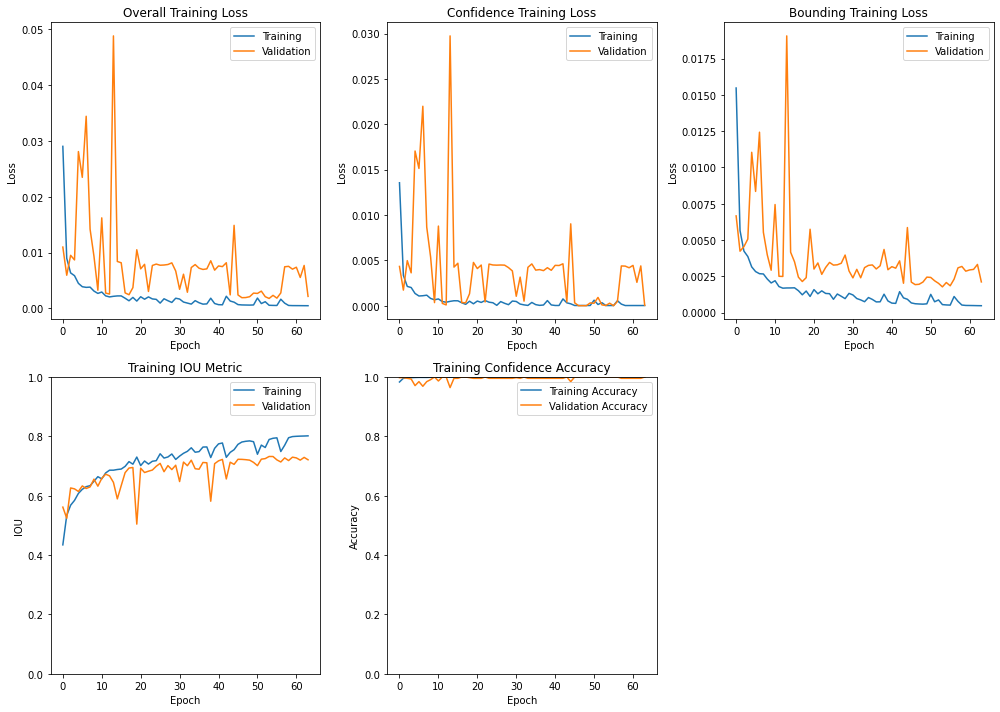

In [8]:
def plot_history(history):
    fig, ax = plt.subplots(2, 3, figsize=(14,10))
    
    ax[0,0].set_title('Overall Training Loss')
    ax[0,0].set_xlabel('Epoch')
    ax[0,0].set_ylabel('Loss')
    ax[0,0].plot(history.history['loss'], label='Training')
    ax[0,0].plot(history.history['val_loss'], label='Validation')
    ax[0,0].legend()
    
    ax[0,1].set_title('Confidence Training Loss')
    ax[0,1].set_xlabel('Epoch')
    ax[0,1].set_ylabel('Loss')
    ax[0,1].plot(history.history['confidence_output_loss'], label='Training')
    ax[0,1].plot(history.history['val_confidence_output_loss'], label='Validation')
    ax[0,1].legend()
    
    ax[0,2].set_title('Bounding Training Loss')
    ax[0,2].set_xlabel('Epoch')
    ax[0,2].set_ylabel('Loss')
    ax[0,2].plot(history.history['bounding_output_loss'], label='Training')
    ax[0,2].plot(history.history['val_bounding_output_loss'], label='Validation')
    ax[0,2].legend()
    
    ax[1,0].set_title('Training IOU Metric')
    ax[1,0].set_xlabel('Epoch')
    ax[1,0].set_ylabel('IOU')
    ax[1,0].set_ylim([0, 1])
    ax[1,0].plot(history.history['bounding_output_iou__metric'], label='Training')
    ax[1,0].plot(history.history['val_bounding_output_iou__metric'], label='Validation')
    ax[1,0].legend()
    
    ax[1,1].set_title('Training Confidence Accuracy')
    ax[1,1].set_xlabel('Epoch')
    ax[1,1].set_ylabel('Accuracy')
    ax[1,1].set_ylim([0, 1])
    ax[1,1].plot(history.history['confidence_output_binary_accuracy'], label='Training Accuracy')
    ax[1,1].plot(history.history['val_confidence_output_binary_accuracy'], label='Validation Accuracy')
    ax[1,1].legend()
    
    ax[1,2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
plot_history(history)

## Looking at the Results

Below are the final results on the test data. The values of overall loss, confidence loss, bounding box loss, confidence accuracy, and IOU on the test data are shown.

In [9]:
test_results = model.evaluate(test_datagen)
print('Test Data Loss: {}'.format(test_results[0]))
print('Test Data Confidence Loss: {}'.format(test_results[1]))
print('Test Data Bounding Loss: {}'.format(test_results[2]))
print('Test Data Binary Accuracy: {}'.format(test_results[3]))
print('Test Data IOU: {}'.format(test_results[4]))

9/9 [==============================] - 2s 181ms/step - loss: 0.0152 - confidence_output_loss: 0.0104 - bounding_output_loss: 0.0049 - confidence_output_binary_accuracy: 0.9896 - bounding_output_iou__metric: 0.6742
Test Data Loss: 0.01522857416421175
Test Data Confidence Loss: 0.010377292521297932
Test Data Bounding Loss: 0.004851282108575106
Test Data Binary Accuracy: 0.9895833134651184
Test Data IOU: 0.6741910576820374


Below, a sample video showing training, validation, and test data are shown. The target data is shown as a red bounding box. The predicted data is shown as a green bounding box. The confidence value and IOU value are displayed at the top left.

In [10]:
display(play_images_from_directory('./data/train/positive/', 'annotations.json', num_to_iter=50, model=model))
display(play_images_from_directory('./data/validation/', 'annotations.json', num_to_iter=1, model=model))
display(play_images_from_directory('./data/test/', 'annotations.json', num_to_iter=1, model=model))

Below, the model is run on several unlabeled videos. There is no labeled target data, so only green boxes are shown. Also, no IOU data is available since there are no target boxes to measure overlap.

In [11]:
def play_images_from_video(video_path, model, interval=100, prediction_threshold=0.5):
    fig, ax = plt.subplots(figsize=(5, 5))
    cap = cv2.VideoCapture(video_path)
    animation_images = []
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            image_copy = cv2.resize(frame, (224, 224))
            image_copy = np.array(image_copy, dtype='float32') / 255.0
            prediction = model.predict(np.reshape(image_copy, (1, 224, 224, 3)))
            conf_pred = prediction[0][0][0]
            iou_result = 0.0
            if conf_pred > prediction_threshold:
                pred_y1 = prediction[1][0][0] * 720
                pred_x1 = prediction[1][0][1] * 960
                pred_y2 = prediction[1][0][2] * 720
                pred_x2 = prediction[1][0][3] * 960
                cv2.rectangle(frame, (int(pred_x1), int(pred_y1)), (int(pred_x2), int(pred_y2)), (0, 255, 0), 2)
            cv2.putText(frame, 'Conf: {:.2f}'.format(conf_pred), (2, 36), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 0), 2, cv2.LINE_AA)
            animation_images.append([ax.imshow(frame.astype('int'))])
        else:
            break
    cap.release()
    ani = animation.ArtistAnimation(fig, animation_images, interval=interval, blit=True)
    plt.close()
    return HTML(ani.to_html5_video())

display(play_images_from_video('../../data/original/videos/video_1.mp4', model))
display(play_images_from_video('../../data/original/videos/video_2.mp4', model))
display(play_images_from_video('../../data/original/videos/video_3.mp4', model))
display(play_images_from_video('../../data/original/videos/video_4.mp4', model))
display(play_images_from_video('../../data/original/videos/video_5.mp4', model))

## Summary

In summary, this project was done just for practice. I wanted to go through the process of beginning with nothing and creating a working model. I created and labeled my own dataset, made the model, and iteratively worked on improving it until it worked to an acceptable level.

While the model works on my dataset and videos of me from my webcam, it doesn't work well with videos from other sources. In order to make the model more robust, I would need labeled images from other camera types, with different people, different angles, and more differences. Since this project was just for practice, I don't plan to pursue improving it any further.